In [2]:
from sgp4.api import Satrec
from sgp4.api import jday
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord, TEME
from datetime import timedelta, datetime
import pandas as pd
import requests
import json
import configparser
from tqdm import tqdm
from math import sqrt
import json
import requests
import configparser
import time

from math import exp

In [2]:
def str_to_datetime(date_str):

    return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
def get_discos_tle_objects(SATNO_CHUNK_STR):
    response = requests.get(
        f'{DISCOS_URL}/api/objects',
        headers={
            'Authorization': f'Bearer {DISCOS_TOKEN}',
            'DiscosWeb-Api-Version': '2',
        },
        params={
            'filter': f'in(satno,{SATNO_CHUNK_STR})',
            'page[size]': f'{DISCOS_PAGE_SIZE_MAX}',
            'sort': 'satno',            
        }
    )
    doc = response.json()
    DISCOS_OBJECTS = doc['data']
    return DISCOS_OBJECTS
def get_ObjectType(requestFindObjects):
 
    r_f_d =f'/class/gp/NORAD_CAT_ID/{str(requestFindObjects)}/orderby/CCSDS_OMM_VERS%20asc/'
    # Use configparser package to pull in the ini file (pip install configparser)
    config = configparser.ConfigParser()
    config.read("./Login.ini")
    configUsr = config.get("configuration", "username")
    configPwd = config.get("configuration", "password")
    siteCred = {'identity': configUsr, 'password': configPwd}

    with requests.Session() as session:
        # run the session in a with block to force session to close if we exit
        uriBase = "https://www.space-track.org"
        requestLogin = "/ajaxauth/login"
        requestCmdAction = "/basicspacedata/query"
        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        response = session.post(uriBase + requestLogin, data=siteCred)
        if response.status_code != 200:
            print("Error, POST fail on login")

        # this query picks up objects from the catalog. Note - a 401 failure shows you have bad credentials
        response = session.get(uriBase + requestCmdAction + r_f_d)

        if response.status_code != 200:
            print("Error, GET fail on request")

        data = json.loads(response.text)
        result = {}

    # Extract 'NORAD_CAT_ID' and 'OBJECT_TYPE' from the data and add it to the result dictionary
        for item in tqdm(data):
            norad_cat_id = item['NORAD_CAT_ID']
            object_type = item['OBJECT_TYPE']
            result[norad_cat_id] = object_type

 
        # print(data)
        # for object in data:
        #     # print(object)
        #     OBJECT_TYPE = object['OBJECT_TYPE']
            

        session.close()
        

    return result 
def calculate_radius(my_dic,primary):
    if primary['shape']=='Box + 2 Pan' and my_dic['shape']==None:
        return 0
        

    from math import sqrt

    if my_dic['shape'] == 'Box + 2 Pan' :
        if my_dic['span'] !=None:
            HBR = my_dic['span']/2
        else:
            depth1 = my_dic['depth']
            width1 = my_dic['width']
            height1 = my_dic['height']
            HBR = sqrt(height1**2+(2*width1+depth1)**2)/2
        HBR = HBR/1000
        
        
    elif my_dic['shape']== 'Box + 1 Pan':
        if my_dic['span'] !=None:
            HBR = my_dic['span']/2
        else:
            depth1 = my_dic['depth']
            width1 = my_dic['width']
            height1 = my_dic['height']
            HBR = sqrt(height1**2+(2*width1+depth1)**2)/2
        HBR = HBR/1000 

    elif my_dic['shape'] == 'Box' :
        if my_dic['span'] !=None:
            HBR = my_dic['span']/2
        else:
            height1 = my_dic['height']
            width1 = my_dic['width']
            depth1 = my_dic['depth']
            HBR = sqrt(height1**2+width1**2+depth1**2)/2
        HBR = HBR/1000      

    elif my_dic['shape'] == 'Sphere':
        
        if my_dic['span'] !=None:
            HBR = my_dic['span']/2
        elif my_dic['diameter'] != None:
            HBR =my_dic['diameter']/2
        else:
            depth1 = my_dic['depth']
            width1 = my_dic['width']
            height1 = my_dic['height']
            HBR = max(height1,depth1,width1)
        HBR = (HBR)/1000 

    elif my_dic['shape'] == 'Cyl':
        if my_dic['span'] !=None:
            HBR = my_dic['span']/2  
        elif my_dic['diameter'] != None:
            HBR =my_dic['diameter'] /2    
        elif my_dic['depth']==None:
            HBR=0
        else:
            depth1 = my_dic['depth']
            width1 = my_dic['width']
            x=depth1+width1
            height1 = my_dic['height']
            HBR = sqrt(x**2+height1**2)/2

        HBR = HBR/1000
    elif my_dic['shape'] == None:
        return 0.001

    else:
        HBR=0.0015
    return round(HBR,6)

### 데이터 호출 후 48시간 이내의 pair만 추출

In [15]:
#  spacemap, celestrak 초기 데이터 호출
PPDB = pd.read_excel("C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/2023-10-24-08-PPDB.xlsx")
Celes = pd.read_csv("C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/sort-minRange_24d_08.csv")
# PPDB = pd.read_excel("C:/Users/kuils/Desktop/프로그래밍/TLE\MYTLE/spacemap_prj/test/2023-10-24-08-PPDB.xlsx")
# Celes = pd.read_csv("C:/Users/kuils/Desktop/프로그래밍/TLE\MYTLE/spacemap_prj/test/sort-minRange_24d_08.csv")
print('초기 PPDB pair 수:',len(PPDB))
print('초기 CELESTRAK pair 수:', len(Celes))

# celestrak 데이터를 48시간 이내로 필터링
Celes = Celes[(Celes['TCA']>='2023-10-24 08:00') & (Celes['TCA']<='2023-10-26 08:00')]
print('48시간 이내 Celestrak의 pair 개수 : ',len(Celes))

초기 PPDB pair 수: 254389
초기 CELESTRAK pair 수: 68387
48시간 이내 Celestrak의 pair 개수 :  19439


### celestrak과 일치하는 pair들만 추출 + 타입

In [61]:
# pair가 일치하는 경우만 다시 추출
filtered_rows  = pd.DataFrame(columns=['PRIMARY','SECONDARY','DCA','TCA','Celestrak_index'])

for i in tqdm((list(Celes.index))):
      obj1 = Celes['NORAD_CAT_ID_1'][i]
      obj2 = Celes['NORAD_CAT_ID_2'][i]

      tca = str_to_datetime(Celes['TCA'][i])
      # pair의 번호가 일치하는 것만 추출
      # primary와 secondary 순서는 고려 안함 
      temp = PPDB[((PPDB['PRIMARY'] == obj1) & (PPDB['SECONDARY'] == obj2)) ]
      temp2 = PPDB[((PPDB['PRIMARY'] == obj2) & (PPDB['SECONDARY'] == obj1))]
      temp.reset_index(drop=True, inplace=True)
      temp2.reset_index(drop=True, inplace=True)
      
      for j in range(len(temp)):
            integer_part = int(temp['SECOND'][j])
            decimal_part = int((temp['SECOND'][j] - integer_part)*1000000)
            # 1분이내에 있는 것만 필터링
            if abs(tca - datetime(temp['YEAR'][j],temp['MONTH'][j],temp['DAY'][j],temp['HOUR'][j],\
                                  temp['MINUTE'][j],integer_part,decimal_part)) <=timedelta(minutes=1):
                  filtered_rows = pd.concat([filtered_rows, pd.DataFrame({\
                        'PRIMARY': [obj1],'SECONDARY':[obj2],'DCA':[temp['DCA'][j]],'TCA':[datetime(temp['YEAR'][j],temp['MONTH'][j],temp['DAY'][j],temp['HOUR'][j],\
                                  temp['MINUTE'][j],integer_part,decimal_part)],'Celestrak_index':[i]})], ignore_index=True)   
                  
      col1 = 'PRIMARY'  # 첫 번째 열의 이름
      col2 = 'SECONDARY'  # 두 번째 열의 이름

      # 열 위치를 바꿉니다.
      temp2 = temp2[[col2, col1] + [col for col in temp2.columns if col not in [col1, col2]]]
      temp2 = temp2.rename(columns={'PRIMARY': 'SECONDARY', 'SECONDARY': 'PRIMARY'})

      for j in range(len(temp2)):
            integer_part = int(temp2['SECOND'][j])
            decimal_part = int((temp2['SECOND'][j] - integer_part)*1000000)
            # 1분이내에 있는 것만 필터링
            if abs(tca - datetime(temp2['YEAR'][j],temp2['MONTH'][j],temp2['DAY'][j],temp2['HOUR'][j],\
                                  temp2['MINUTE'][j],integer_part,decimal_part)) <=timedelta(minutes=1):
                  filtered_rows = pd.concat([filtered_rows, pd.DataFrame({\
                        'PRIMARY': [obj1],'SECONDARY':[obj2],'DCA':[temp2['DCA'][j]],'TCA':[datetime(temp2['YEAR'][j],temp2['MONTH'][j],temp2['DAY'][j],temp2['HOUR'][j],\
                                  temp2['MINUTE'][j],integer_part,decimal_part)],'Celestrak_index':[i]})], ignore_index=True)   
                  
                 
# 48시간 이내에 celestrak 결과에 있는 pair만 저장됨                 
PPDB_48h = pd.DataFrame(filtered_rows)
print('1분이내로 필터링 된 개수 :',len(PPDB_48h))

# 이전과정을 OBJECT 타입까지 csv로 저장
ObjType = get_ObjectType('1--90000') #위성번호 1번부터 90000까지의 object type을 spacetrack에서 가져옴
PPDB_48h['OBJECT TYPE1'] = None
PPDB_48h['OBJECT TYPE2'] = None
PPDB_48h['OBJECT1'] = None
PPDB_48h['OBJECT2'] = None
for i in tqdm(range(len(PPDB_48h))):

    obj1 = int(PPDB_48h['PRIMARY'].iloc[i])
    obj2 = int(PPDB_48h['SECONDARY'].iloc[i])


    PPDB_48h.at[i, 'OBJECT TYPE1'] = ObjType[str(obj1)]
    PPDB_48h.at[i, 'OBJECT TYPE2'] = ObjType[str(obj2)]
    PPDB_48h.at[i, 'OBJECT1'] = obj1
    PPDB_48h.at[i, 'OBJECT2'] = (obj2)
PPDB_48h.to_csv("C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/PPDB_48h.csv", index=False)

  0%|          | 0/19439 [00:00<?, ?it/s]C:\Users\VDRC\AppData\Local\Temp\ipykernel_20224\3391521773.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_rows = pd.concat([filtered_rows, pd.DataFrame({\
100%|██████████| 19439/19439 [01:08<00:00, 283.31it/s]


1분이내로 필터링 된 개수 : 19097


100%|██████████| 19097/19097 [00:02<00:00, 9112.47it/s]


### discosweb에서 dimension정보 불러와 저장

In [196]:
DISCOS_URL = 'https://discosweb.esoc.esa.int'
DISCOS_TOKEN = 'Ijk1YjRjMWYwLTc1ZDItNDc4NS04MzQ4LTgyZmM3MDk2M2IyYiI.lqet3mWHZooxHwUGaRqLBOTvYjI'
DISCOS_SATNO_MAX = 56685
DISCOS_PAGE_SIZE_MAX = 100

uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestCmdAction = "/basicspacedata/query"
requestFindObjects = f"/class/tle_latest/NORAD_CAT_ID/<{DISCOS_SATNO_MAX+1}/ORDINAL/1/format/json/orderby/NORAD_CAT_ID%20asc"


In [64]:
#id 1번 2번 설정.
if __name__ == '__main__':
    SATNO_LIST = list(PPDB_48h['SECONDARY'].astype(int))[:20000]
    SATNO_LIST = [str(item) for item in SATNO_LIST]
    SATNO_LIST_CHUNK = [
            SATNO_LIST[i:i+100] 
            for i in range(0, len(SATNO_LIST), 100)
            ]
    dic_set = dict()
    for idx, chk in enumerate(SATNO_LIST_CHUNK):
            
                
        SATNO_CHUNK_STR = '(' + ','.join(chk) + ')'
        DISCOS_OBJECTS = get_discos_tle_objects(SATNO_CHUNK_STR) # ID에 해당하는 DISCOS 정보 불러오기 
        for obj in DISCOS_OBJECTS:
                
            dic_set[obj['attributes']['satno']] = obj['attributes']
        
        if (idx + 1) % 20 == 0:
            print(f'when {idx}th index, sleep')
            time.sleep(61)
    #파일 이름 설정
    with open(f'./test/size_24d08h_secondary3.txt', 'w') as file:
        json.dump(dic_set, file, indent='\t')

when 19th index, sleep
when 39th index, sleep
when 59th index, sleep
when 79th index, sleep
when 99th index, sleep
when 119th index, sleep
when 139th index, sleep
when 159th index, sleep
when 179th index, sleep


### 계산할 pair 정보와  dimension정보 불러오기

In [3]:
PPDB_48h = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/PPDB_48h.csv')
# PPDB_48h = pd.read_csv('C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/test/PPDB_48h.csv')

# file_celestrak = 'C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/test/24d08h_primaryDimension.txt'
file_celestrak = 'C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/24d08h_primaryDimension.txt'
with open(file_celestrak, "r") as file:
    size_dic_p = json.load(file)
# file_celestrak = 'C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/test/24d08h_primaryDimension.txt'
file_celestrak = 'C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/24d08h_secondaryDimension.txt'
with open(file_celestrak, "r") as file:
    size_dic_s = json.load(file)

### shape, objectclass, object type 으로 분류

In [ ]:
data_total =  pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/test_24d08h_total5.csv')
data_total = data_total[1::2]
data1 = data_total[data_total['Error(ratio)']<=0.5]
data2 = data_total[data_total['Error(ratio)']>0.5]
pair위 = data2.groupby(['Shape1', 'Shape2','OBJECT_CLASS1','OBJECT_CLASS2','OBJECT_TYPE1','OBJECT_TYPE2']).size().reset_index(name='Count')


pair아래 = data1.groupby(['Shape1', 'Shape2','OBJECT_CLASS1','OBJECT_CLASS2','OBJECT_TYPE1','OBJECT_TYPE2']).size().reset_index(name='Count')

# pair위와 pair아래의 결과를 따로 저장
pair위.to_csv('./pair위.csv', index=False)
pair아래.to_csv('./pair아래.csv', index=False)

# pair위와 pair아래를 병합하여 combined_pair DataFrame 생성
combined_pair = pair위.merge(pair아래, on=['Shape1', 'Shape2','OBJECT_CLASS1','OBJECT_CLASS2','OBJECT_TYPE1','OBJECT_TYPE2'], how='outer')
combined_pair.columns = ['Shape1', 'Shape2','OBJECT_CLASS1','OBJECT_CLASS2','OBJECT_TYPE1','OBJECT_TYPE2',  'upper','lower']
# 합쳐진 DataFrame을 CSV 파일로 저장
combined_pair.to_csv('./combined_pair.csv', index=False)

### 확률계산 후 csv 저장 
1. NORAD_CAT_ID
2. OBJECT_NAME
3. Shape
4. Object_Type
5. TCA
6. TCA_RANGE
7. TCA_RELATIVE_SPEED
8. Radius
9. Pc
10. Error

In [116]:
#2분소요
result_df = pd.DataFrame(columns=['Category','Index','NORAD_CAT_ID_1','OBJECT_NAME_1','Shape1','OBJECT_TYPE1','OBJECT_CLASS1',\
                                  'NORAD_CAT_ID_2','OBJECT_NAME_2','Shape2','OBJECT_TYPE2','OBJECT_CLASS2','TCA',\
                                  'TCA_RANGE','TCA_RELATIVE_SPEED','Dilution','Radius1','Radius2','HBR','Pc_celestrak','Pc_Alfano','Error(ratio)',\
                                    ])
pair = pd.read_csv('./combined_pair.csv')
pair = pair.fillna(0)

'''
esa에 dimension정보가 없으면 상수 값으로 대체
but, DEBRIS는 30cm로 설정. 일반적인 PRIMARY는 3m , SECONDARY는 1.5m 
'''
result_data=[]
for i in tqdm(range(len(PPDB_48h))): 
    if str(int(PPDB_48h['PRIMARY'][i])) in size_dic_p.keys():
        t1 = size_dic_p[str(int(PPDB_48h['PRIMARY'][i]))]
        # if (t1['shape']) is None:
        #     t1['shape']='Unknown'
        # if (t1['objectClass']) is None:
        #     t1['objectClass']='Unknown'
        hbr1 = calculate_radius(t1,t1)
        if PPDB_48h['OBJECT TYPE1'][i]=='DEBRIS':
            hbr1=0.0003

    else : 
        if PPDB_48h['OBJECT TYPE1'][i]=='DEBRIS':
            hbr1=0.0003
        else:
            hbr1=0.0015
        t1={'shape':'Unknown','objectClass':'Unknown'}

    if str(int(PPDB_48h['SECONDARY'][i])) in size_dic_s.keys():
        t2= size_dic_s[str(int(PPDB_48h['SECONDARY'][i]))]
        # if (t2['shape'])is None:
        #     t2['shape']='Unknown'
        # if t2['objectClass']is None:
        #     t2['objectClass']='Unknown'
        hbr2 = calculate_radius(t2,t1)
        if PPDB_48h['OBJECT TYPE2'][i]=='DEBRIS':
            hbr2=0.0003
    else : 

      
        t2={'shape':'Unknown','objectClass':'Unknown'}
        if PPDB_48h['OBJECT TYPE2'][i]=='DEBRIS':
            hbr2=0.0003
        else:
            hbr2=0.0015
    hbr=hbr1+hbr2
    # # print(t1['shape'],str(t2['shape']),t1['objectClass'],t2['objectClass'],PPDB_48h['OBJECT TYPE1'][i],PPDB_48h['OBJECT TYPE2'][i])
    # temp =pair[(pair['Shape1']==t1['shape'])&(pair['Shape2']==t2['shape'])
    #  &(pair['OBJECT_CLASS1']==t1['objectClass'])&(pair['OBJECT_CLASS2']==t2['objectClass'])
    #  &(pair['OBJECT_TYPE1']==PPDB_48h['OBJECT TYPE1'][i])&(pair['OBJECT_TYPE2']==PPDB_48h['OBJECT TYPE2'][i])]
    
    # if temp['lower'].values[0]>temp['upper'].values[0]:
    #     hbr=0.005
    # else:
    #     hbr=0.0015
    
    AR=3
    Range=PPDB_48h['DCA'][i]
    sd_max = Range/sqrt(2)
    Celestrak_index= int(PPDB_48h['Celestrak_index'][i])
    prob_celestrak = Celes['MAX_PROB'][Celestrak_index]
    prob_Alfano = exp(-Range**2/(2*sd_max**2))*(1-exp(-AR*hbr**2/(2*sd_max**2)))
    if prob_Alfano<1.3e-07:
        hbr+=0.0017 * 2/Range
        
        prob_Alfano = exp(-Range**2/(2*sd_max**2))*(1-exp(-AR*hbr**2/(2*sd_max**2)))
    result_data.append({
        'Category': 'Celestrak',
        'Index': i,
        'NORAD_CAT_ID_1':Celes['NORAD_CAT_ID_1'][Celestrak_index],
        'OBJECT_NAME_1': Celes['OBJECT_NAME_1'][Celestrak_index],
        'Shape1':t1['shape'],'OBJECT_CLASS1':t1['objectClass'],
        'OBJECT_TYPE1':PPDB_48h['OBJECT TYPE1'][i],
        
        'NORAD_CAT_ID_2':Celes['NORAD_CAT_ID_2'][Celestrak_index], 
        'OBJECT_NAME_2':Celes['OBJECT_NAME_2'][Celestrak_index],
        'Shape2':t2['shape'],'OBJECT_CLASS2':t2['objectClass'],
        'OBJECT_TYPE2':PPDB_48h['OBJECT TYPE2'][i],

        'TCA':Celes['TCA'][Celestrak_index],\
        'TCA_RANGE':Celes['TCA_RANGE'][Celestrak_index], 
        'TCA_RELATIVE_SPEED':Celes['TCA_RELATIVE_SPEED'][Celestrak_index] ,
        'Dilution':Celes['DILUTION'][Celestrak_index],\
        'Radius1':hbr1,'Radius2':hbr2,'HBR':hbr,
        'Pc_celestrak':prob_celestrak,'Pc_Alfano':prob_Alfano, 'Error(ratio)':0,\
        
    })
    result_data.append({
        'Category': 'spacemap',
        'Index': i,
        'NORAD_CAT_ID_1':PPDB_48h['PRIMARY'][i],
        'OBJECT_NAME_1': Celes['OBJECT_NAME_1'][Celestrak_index],
        'Shape1':t1['shape'],'OBJECT_CLASS1':t1['objectClass'],
        'OBJECT_TYPE1':PPDB_48h['OBJECT TYPE1'][i],
        
        'NORAD_CAT_ID_2':PPDB_48h['SECONDARY'][i], 
        'OBJECT_NAME_2':Celes['OBJECT_NAME_2'][Celestrak_index],
        'Shape2':t2['shape'],'OBJECT_CLASS2':t2['objectClass'],
        'OBJECT_TYPE2':PPDB_48h['OBJECT TYPE2'][i],

        'TCA':PPDB_48h['TCA'][i],
        'TCA_RANGE':Range, 
        'TCA_RELATIVE_SPEED':Celes['TCA_RELATIVE_SPEED'][Celestrak_index] ,
        'Dilution':Celes['DILUTION'][Celestrak_index],
        'Radius1':hbr1,'Radius2':hbr2,'HBR':hbr,
        'Pc_celestrak':prob_celestrak,'Pc_Alfano':prob_Alfano, 'Error(ratio)':(prob_Alfano)/(prob_celestrak),\
        
    })

result_df = pd.DataFrame(result_data)
result_df.to_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/test_24d08h_total3.csv', index=False)      

100%|██████████| 19097/19097 [00:02<00:00, 6585.52it/s]


## **celestrak과 spacemap 확률 비교**

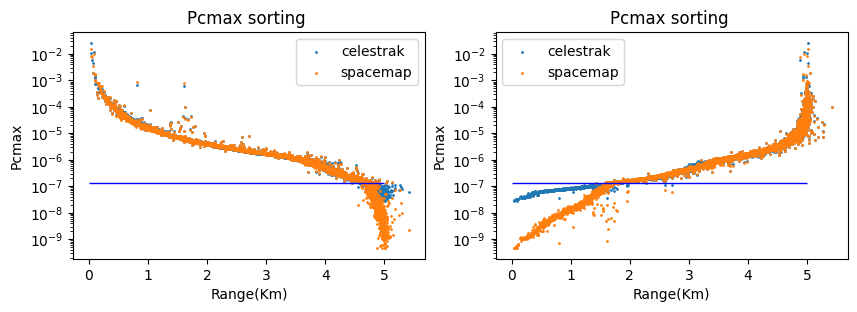

In [4]:

fig = plt.figure(figsize=(10,10))
ax1=fig.add_subplot(3,2,1)
ax2=fig.add_subplot(3,2,2)



data_total1 =  pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/PcmaxUsingPPDB/result/test_24d08h_total2.csv')
data_total1 = data_total1[1::2]
ax1.scatter(data_total1['TCA_RANGE'],data_total1['Pc_celestrak'].sort_values(ascending=False),s=1,label='celestrak')
ax1.scatter(data_total1['TCA_RANGE'],data_total1['Pc_Alfano'].sort_values(ascending=False),s=1,label='spacemap')
# data_total1= data_total1.sort_values(by='Pc_celestrak')
ax1.hlines(1.3e-07, 0, 5, color='b', linestyle='solid', linewidth=1)
ax1.set_yscale('log')
ax1.set_title('Pcmax sorting ')
ax1.set_xlabel('Range(Km)')
ax1.set_ylabel('Pcmax')
ax1.legend()

ax2.scatter(data_total1['TCA_RANGE'],data_total1['Pc_celestrak'].sort_values(ascending=True),s=1,label='celestrak')
ax2.scatter(data_total1['TCA_RANGE'],data_total1['Pc_Alfano'].sort_values(ascending=True),s=1,label='spacemap')
# data_total1= data_total1.sort_values(by='Pc_celestrak')
ax2.hlines(1.3e-07, 0, 5, color='b', linestyle='solid', linewidth=1)
ax2.set_yscale('log')
ax2.set_title('Pcmax sorting ')
ax2.set_xlabel('Range(Km)')
ax2.set_ylabel('Pcmax')
ax2.legend()




### Error(ratio) Scatter 시각화
1. 전체 scatter
2. 0.1배 10배 이내 scatter
3. 0.5배 2배 이내 scatter

총 pair 개수: 19097.0
1e-1 범위 밖 개수: 4962
1e-1 범위 내 개수 : 14135
범위 밖 비율 : 25.98%
범위 내 비율 : 74.02%


Text(14135, 0.1000014581779373, '0.0500')

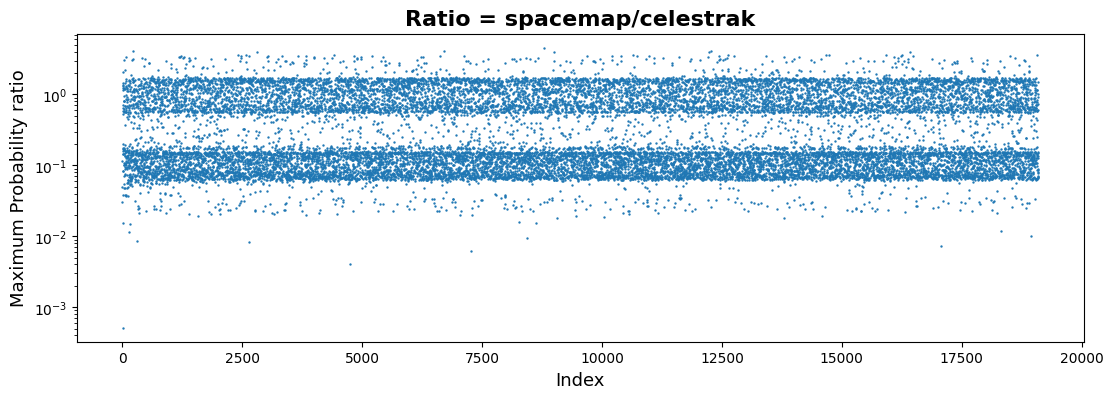

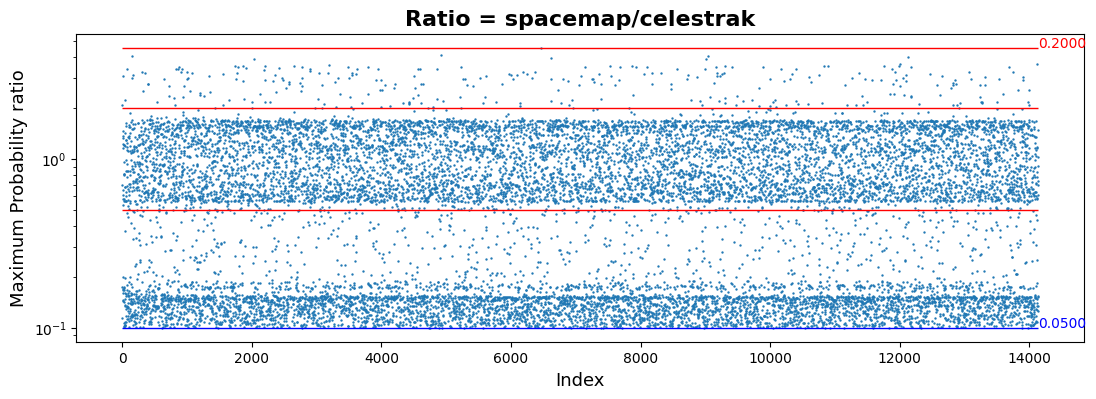

In [5]:
plt.figure(figsize=(13,4))
data_total =  pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/PPDB vs Celestrak/result/test_24d08h_total5.csv')

# data_total =  pd.read_csv('C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/test/test_24d08h_total5.csv')



data_valid  = [value for value in data_total['Error(ratio)'][1::2] if value >= 0.1 and value <= 10 ]

plt.scatter(np.arange(len(data_total['Error(ratio)'][1::2])),data_total['Error(ratio)'][1::2] ,s=0.5)
plt.title('Ratio = spacemap/celestrak', fontsize=16, fontweight='bold')
plt.xlabel(xlabel="Index",fontsize=13)
plt.ylabel(ylabel="Maximum Probability ratio",fontsize=13)
plt.yscale('log')

print("총 pair 개수:", len(data_total)/2)
print("1e-1 범위 밖 개수:", len(data_total['Error(ratio)'][1::2])- len(data_valid))
print('1e-1 범위 내 개수 :',len(data_valid))
print(f"범위 밖 비율 : {round((len(data_total['Error(ratio)'][1::2])- len(data_valid))*100/len(data_total['Error(ratio)'][1::2]),2)}%")
print(f"범위 내 비율 : {round(len(data_valid)*100/len(data_total['Error(ratio)'][1::2]),2)}%")

# plt.hlines(max(data_valid), 0, len(data_total['Error(ratio)'][1::2]), color='red', linestyle='solid', linewidth=1)
# plt.hlines(np.min(np.array(data_valid)), 0, len(data_total['Error(ratio)'][1::2]), color='r', linestyle='solid', linewidth=1)
# plt.hlines(0.2, 0, len(data_total['Error(ratio)'][1::2]), color='b', linestyle='solid', linewidth=1)
# # plt.hlines(0.05, 0, len(data_total['Error(ratio)'][1::2]), color='b', linestyle='solid', linewidth=1)
# plt.text(len(data_total['Error(ratio)'][1::2]), max(data_valid), f'{2:.4f}', fontsize=10, color='red')
# plt.text(len(data_total['Error(ratio)'][1::2]), np.min(np.array(data_valid)), f'{0.5:.4f}', fontsize=10, color='r')
# plt.text(len(data_total['Error(ratio)'][1::2]), 0.2, f'{0.2:.4f}', fontsize=10, color='b')
# plt.text(len(data_total['Error(ratio)'][1::2]), 0.05, f'{0.05:.4f}', fontsize=10, color='b')
plt.figure(figsize=(13,4))
# 특정 범위내 scatter
plt.scatter(np.arange(len(data_valid)),data_valid,s=0.5)
plt.title('Ratio = spacemap/celestrak', fontsize=16, fontweight='bold')
plt.xlabel(xlabel="Index",fontsize=13)
plt.ylabel(ylabel="Maximum Probability ratio",fontsize=13)
plt.yscale('log')
plt.hlines(2, 0, len(data_valid), color='red', linestyle='solid', linewidth=1)
plt.hlines(0.5, 0, len(data_valid), color='red', linestyle='solid', linewidth=1)

plt.hlines(max(data_valid), 0, len(data_valid), color='red', linestyle='solid', linewidth=1)
plt.hlines(np.min(np.array(data_valid)), 0, len(data_valid), color='b', linestyle='solid', linewidth=1)
plt.text(len(data_valid), max(data_valid), f'{0.2:.4f}', fontsize=10, color='red')
plt.text(len(data_valid), np.min(np.array(data_valid)), f'{0.05:.4f}', fontsize=10, color='b')



### error 와 velocity 분포 (전체)

100%|██████████| 1058/1058 [00:03<00:00, 343.68it/s]


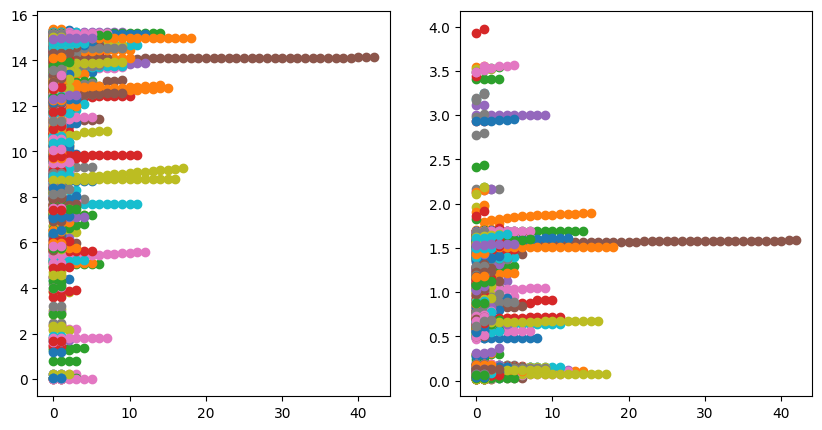

In [121]:
data = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/test_24d08h_total5.csv')
data = data[1::2]
pair = data.groupby(['NORAD_CAT_ID_1', 'NORAD_CAT_ID_2']).agg({'TCA_RELATIVE_SPEED': ['count', 'std']}).reset_index()
pair.columns = ['satno', 'satno2', 'count', 'std_dev']

# Conjunction event 2회이상인 pair만 저장.
fig = plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
pair_2 = pair[pair['count'] > 1]
pair_2 = pair_2.reset_index()
for i in tqdm(range(len(pair_2))):
    temp = data[(data['NORAD_CAT_ID_1']==pair_2['satno'].iloc[i]) & (data['NORAD_CAT_ID_2']==pair_2['satno2'].iloc[i])]
    ax1.scatter(np.arange(0,len(temp)),temp['TCA_RELATIVE_SPEED'].sort_values())
# plt.hlines(2, 0, 20, color='b', linestyle='solid', linewidth=1)
# plt.hlines(0.5, 0, 20, color='b', linestyle='solid', linewidth=1)
# plt.hlines(0.2, 0, 20, color='red', linestyle='solid', linewidth=1)
# plt.hlines(0.05, 0, 20, color='red', linestyle='solid', linewidth=1)
pair_2.to_csv('./pair1.csv')

data = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/test_24d08h_total5.csv')
data = data[1::2]
pair = data.groupby(['NORAD_CAT_ID_1', 'NORAD_CAT_ID_2']).agg({'Error(ratio)': ['count', 'std']}).reset_index()
pair.columns = ['satno', 'satno2', 'count', 'std_dev']

# Conjunction event 2회이상인 pair만 저장.
pair_2 = pair[pair['count'] > 1]
pair_2 = pair_2.reset_index()
for i in tqdm(range(len(pair_2))):
    temp = data[(data['NORAD_CAT_ID_1']==pair_2['satno'].iloc[i]) & (data['NORAD_CAT_ID_2']==pair_2['satno2'].iloc[i])]
    ax2.scatter(np.arange(0,len(temp)),temp['Error(ratio)'].sort_values())
# plt.hlines(2, 0, 20, color='b', linestyle='solid', linewidth=1)
# plt.hlines(0.5, 0, 20, color='b', linestyle='solid', linewidth=1)
# plt.hlines(0.2, 0, 20, color='red', linestyle='solid', linewidth=1)
# plt.hlines(0.05, 0, 20, color='red', linestyle='solid', linewidth=1)
pair_2.to_csv('./pair2.csv')

### Error(ratio) Boxplot 시각화

이상치 개수: 1471
총 개수: 19097
이상치 비율 0.07702780541446301


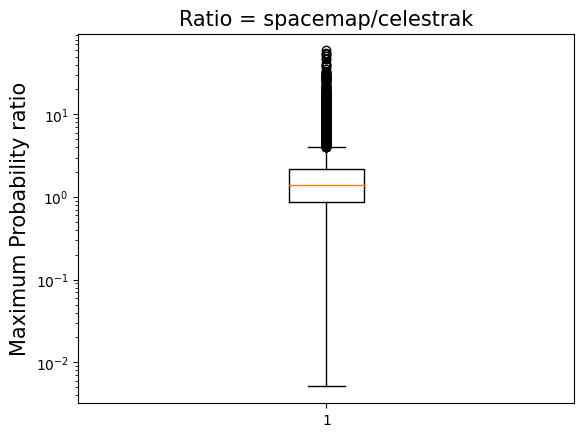

In [120]:

data_trueprob =  pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/test_24d08h_total3.csv')
# data_trueprob =  pd.read_csv('C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/test/test_24d08h_total2.csv')
fig, ax1 = plt.subplots()
ax1.boxplot(data_trueprob['Error(ratio)'][1::2])
# ax1.set_ylim(-2,2)
ax1.set_title('Ratio = spacemap/celestrak',fontsize=15)
ax1.set_ylabel('Maximum Probability ratio',fontsize=15)

ax1.set_yscale('log')
# ax1.set_ylim(1e-08,1e02)



Q1 = np.percentile(data_trueprob['Error(ratio)'][1::2], 25)
Q3 = np.percentile(data_trueprob['Error(ratio)'][1::2], 75)
IQR = Q3 - Q1

# 이상치 경계 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data_trueprob['Error(ratio)'][1::2][(data_trueprob['Error(ratio)'][1::2] < lower_bound) | (data_trueprob['Error(ratio)'][1::2] > upper_bound)]

# 이상치 개수 출력
outlier_count = len(outliers)
total_count = len(data_trueprob['Error(ratio)'][1::2]) 
print("이상치 개수:", outlier_count )
print("총 개수:", total_count )
print("이상치 비율", outlier_count/total_count)

### celestrak'PC ,  Spacemap'Pc 상관계수 구하기

In [27]:
# spacemap 결과만 추출하고 DCA로 정렬
# data_total =  pd.read_csv('C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/test/test_24d08h_total2.csv')
# data_total= pd.read_csv('C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/test/test_24d08h_total2.csv')
data_total =  pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/PcmaxUsingPPDB/result/test_24d08h_total.csv')
# data_total2 = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/test_24d08h_total3지울거.csv')
data=data_total[1::2]
data2=data_total[1::2]
sorted_data = data.sort_values(by='TCA_RANGE')
updated_data = data2.sort_values(by='TCA_RANGE')


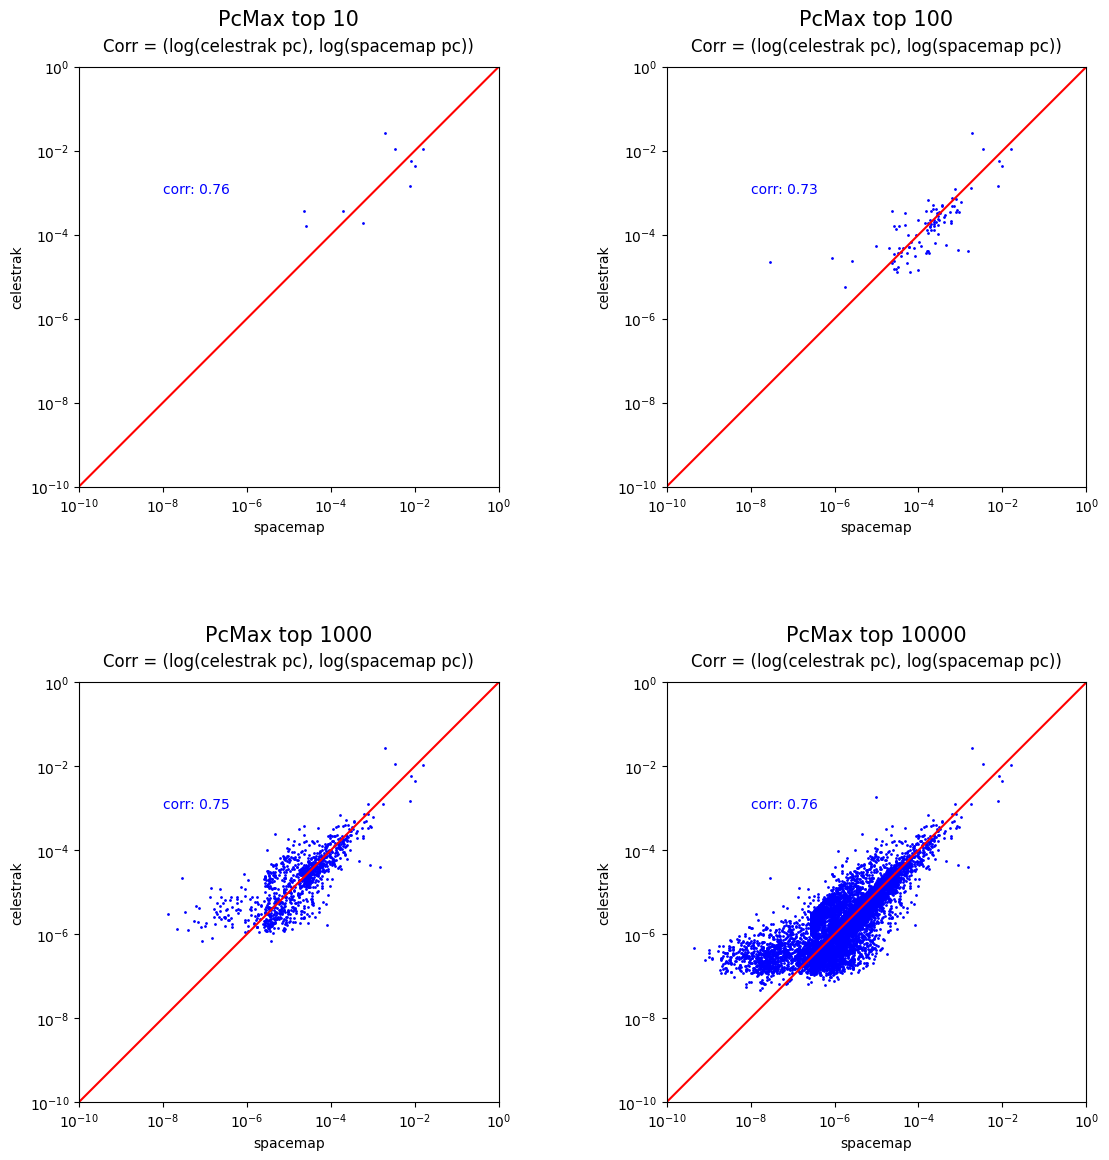

In [28]:

data_list = [sorted_data[:10], sorted_data[:100], sorted_data[:1000], sorted_data[:10000]]
titles = ["PcMax top 10", "PcMax top 100", "PcMax top 1000", "PcMax top 10000"]

fig, axes = plt.subplots(2, 2, figsize=(13, 13))

# Create a loop to iterate through both data lists
for i in range(len(data_list)):
    correlation = np.log10(data_list[i]['Pc_Alfano']).corr(np.log10(data_list[i]['Pc_celestrak']))
    
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    ax.scatter(data_list[i]['Pc_Alfano'], data_list[i]['Pc_celestrak'], s=1, label=f"sorted_data{i+1}", color='b')
    ax.set_title(titles[i], pad=30, fontsize=15)
    ax.set_xlabel('spacemap')
    ax.set_ylabel('celestrak')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-10, 1e-0)
    ax.set_ylim(1e-10, 1e-0)
    ax.text(1E-08, 1E-03, f'corr: {round(correlation, 2)}', fontsize=10, color='b')

    text = 'Corr = (log(celestrak pc), log(spacemap pc))'
    ax.text(0.5, 1.05, text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    x = np.linspace(0, 10, 100)  # 0에서 10까지 100개의 점으로 나눈 범위

   
    # 그래프 그리기
    ax.plot(x, x, color='red')
    ax.set_aspect('equal')

plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.45)
plt.show()

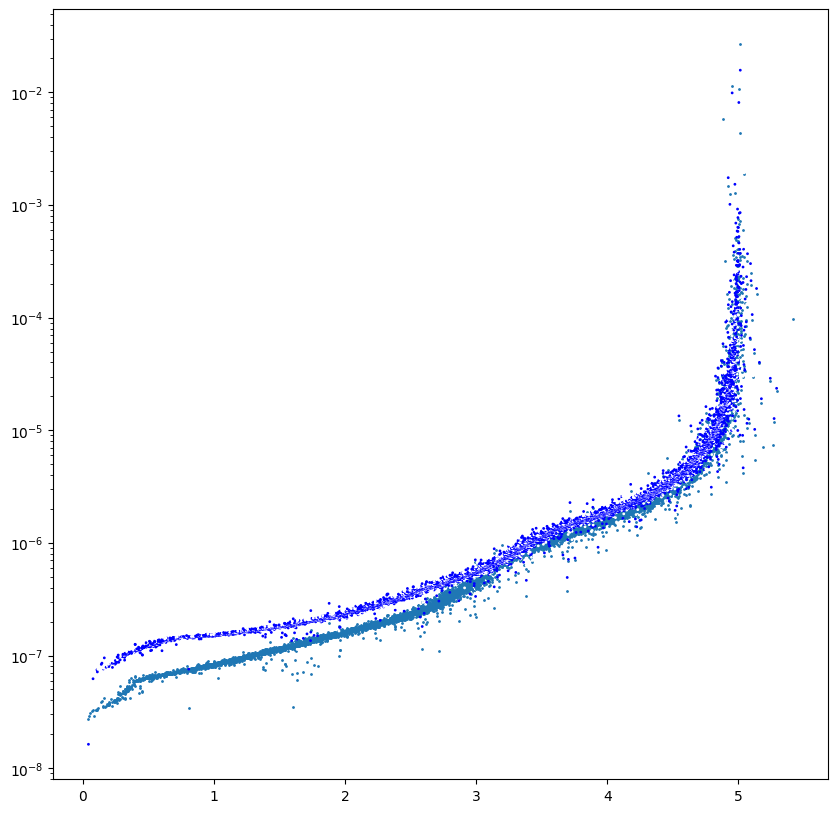

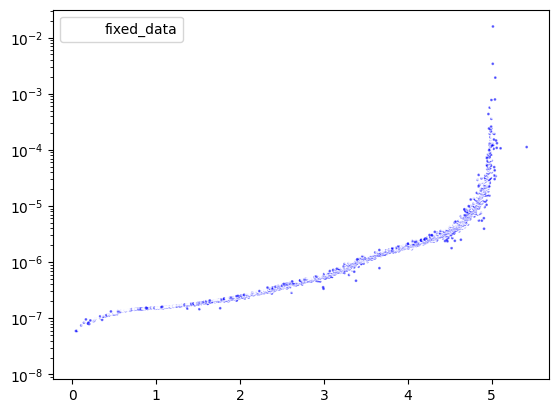

In [186]:
data_total1 = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/test_24d08h_total.csv')
data_total1 = data_total1[1::2]

# 특정 조건에 따라 데이터를 필터링
fixed_data = data_total1[(data_total1['Radius1'] == 0.0015) | (data_total1['Radius2'] == 0.0015)]
unknown_data = data_total1[(data_total1['OBJECT_TYPE1'] == 'UNKNOWN') | (data_total1['OBJECT_TYPE2'] == 'UNKNOWN')]

# 그래프 생성
plt.figure(figsize=(10, 10))

# Pc_celestrak 데이터를 정렬하여 scatter 그래프로 그리기
plt.scatter(data_total1['TCA_RANGE'], data_total1['Pc_celestrak'].sort_values(), s=1, label='celestrak')

# Pc_Alfano 데이터를 정렬하여 scatter 그래프로 그리고 특정 조건을 만족하는 데이터에 대한 색상 설정
scatter = plt.scatter(data_total1['TCA_RANGE'], data_total1['Pc_Alfano'].sort_values(), s=1, label='spacemap')
scatter.set_color(['b' if index in fixed_data.index else 'white' for index in data_total1.index])
plt.yscale('log')
plt.show()
data_total1 = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/test_24d08h_total.csv')
data_total1 = data_total1[1::2]

scatter = plt.scatter(data_total1['TCA_RANGE'], data_total1['Pc_Alfano'].sort_values(), s=1, label='spacemap', alpha=0.5)
scatter.set_color(['b' if index in unknown_data.index else 'white' for index in data_total1.index])
plt.yscale('log')

plt.legend(handles=[scatter], labels=['fixed_data', 'unknown_data', 'Black'])
plt.show()

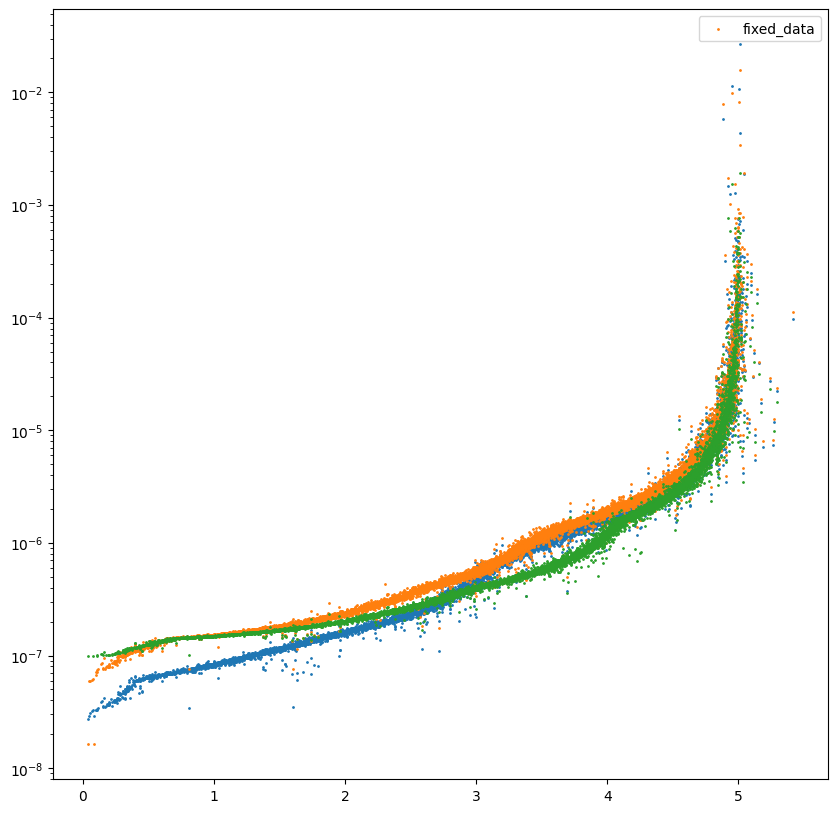

In [165]:
data_total1 = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/test/test_24d08h_total.csv')
data_total1 = data_total1[1::2]

# 특정 조건에 따라 데이터를 필터링
fixed_data = data_total1[(data_total1['Radius1'] == 0.0015) | (data_total1['Radius2'] == 0.0015)]
unknown_data = data_total1[(data_total1['OBJECT_TYPE1'] == 'UNKNOWN') | (data_total1['OBJECT_TYPE2'] == 'UNKNOWN')]

# 그래프 생성
plt.figure(figsize=(10, 10))

# Pc_celestrak 데이터를 정렬하여 scatter 그래프로 그리기
plt.scatter(data_total1['TCA_RANGE'], data_total1['Pc_celestrak'].sort_values(), s=1, label='celestrak')

# Pc_Alfano 데이터를 정렬하여 scatter 그래프로 그리고 특정 조건을 만족하는 데이터에 대한 색상 설정
scatter = plt.scatter(data_total1['TCA_RANGE'], data_total1['Pc_Alfano'].sort_values(), s=1, label='spacemap')
data_total2= data_total1.loc[fixed_data.index]
plt.scatter(data_total2['TCA_RANGE'], data_total2['Pc_Alfano'].sort_values(), s=1, label='celestrak')

plt.yscale('log')

plt.legend(handles=[scatter], labels=['fixed_data', 'unknown_data', 'Black'])
plt.show()